In [10]:
import numpy as np
import rasterio
from rasterio.mask import mask
import pandas as pd
import geopandas as gpd
import fiona
import os

import numpy.ma as ma # for masked arrays. This allows us to handle NAs for integer arrays

import time 

In [2]:
current_nutsid = 'PL72'

In [3]:
nuts_path = "in_data/admin/Forest_area_PL.geojson"


In [4]:
admin_stats = "in_data/admin/PL_landcover.csv"

In [5]:
aggregates = pd.read_csv(admin_stats)
aggregates['misc_ha'] = 0
aggregates['total_ha'] = 0
aggregates.loc[aggregates.NUTSID == current_nutsid,'total_ha'].item()


0

Step 1: Reclass the region so that 311, 312, 313 are 1 and all the rest is 0

In the tif I have the classes are 23, 24, 25 for 311, 312, 313 respectively. 

In [96]:
%%bash 

pkgetmask -ot Byte -min 23 -max 25 -data 1 -nodata 0 \
-i in_data/CLC/u2018_clc2018_v2020_20u1_raster100m/DATA/PL_U2018_CLC2018_V2020_20u1.tif \
-o out_data/CLC/PL_mask_311_312_313.tif

gdal_edit.py -a_nodata 255 out_data/CLC/PL_mask_311_312_313.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Step 2: Multiply this reclassed region with Martin’s forest probability mask

In [64]:
%%bash

pksetmask -i out_data/PL_expert_map_integer.tif  \
-m out_data/CLC/PL_mask_311_312_313.tif \
-o out_data/PL_expert_forest_map_masked_311_312_313.tif \
--maskvalue 0 --setvalue 255

gdal_edit.py -a_nodata 255 out_data/PL_expert_forest_map_masked_311_312_313.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Same for arable cropland
"in_data/Corine_landcover/Crops_ptobability_final_layer_Poland.tif"

In [97]:
%%bash 

pkgetmask -ot Byte -min 12 -max 14 -data 1 -nodata 0 \
-i in_data/CLC/u2018_clc2018_v2020_20u1_raster100m/DATA/PL_U2018_CLC2018_V2020_20u1.tif \
-o out_data/CLC/PL_mask_211_212_213.tif

gdal_edit.py -a_nodata 255 out_data/CLC/PL_mask_211_212_213.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [98]:
%%bash 
pksetmask -i in_data/Corine_landcover/Crops_ptobability_final_layer_Poland.tif  \
-m out_data/CLC/PL_mask_211_212_213.tif \
-o out_data/PL_expert_crop_map_masked_211_212_213.tif \
--maskvalue 0 --setvalue 255

gdal_edit.py -a_nodata 255 out_data/PL_expert_crop_map_masked_211_212_213.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Permanent cropland

In [34]:
%%bash 

masktif="out_data/CLC/PL_mask_242.tif"

pkgetmask -ot Byte -min 20 -max 20 -data 1 -nodata 0 \
-i in_data/CLC/u2018_clc2018_v2020_20u1_raster100m/DATA/PL_U2018_CLC2018_V2020_20u1.tif \
-o $masktif

# gdal_edit.py -a_nodata 255 out_data/CLC/PL_mask_242.tif


0...10...20...30...40...50...60...70...80...90...100 - done.


In [35]:
%%bash 

masktif="out_data/CLC/PL_mask_242.tif"

pksetmask -i in_data/Corine_landcover/Crops_ptobability_final_layer_Poland.tif  \
-m $masktif \
-o out_data/PL_expert_permcrop_map_masked_242.tif \
--maskvalue 0 --setvalue 255

gdal_edit.py -a_nodata 255 out_data/PL_expert_permcrop_map_masked_242.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [30]:
!gdalinfo in_data/Corine_landcover/Crops_ptobability_final_layer_Poland.tif | grep "and 1"
!gdalinfo out_data/PL_expert_permcrop_map_masked_242.tif | grep "and 1" 
!gdalinfo out_data/PL_expert_permcrop_map_masked_242.tif | grep "and 1"

Band 1 Block=7163x1 Type=Byte, ColorInterp=Gray
Band 1 Block=7163x1 Type=Byte, ColorInterp=Gray
Band 1 Block=7163x1 Type=Byte, ColorInterp=Gray


Grassland

"in_data/Corine_landcover/Grass_ptobability_final_layer_Poland.tif"

In [15]:
%%bash 

pkgetmask -ot Byte -min 26 -max 26 -data 1 -nodata 0 \
-i in_data/CLC/u2018_clc2018_v2020_20u1_raster100m/DATA/PL_U2018_CLC2018_V2020_20u1.tif \
-o out_data/CLC/PL_mask_321.tif

gdal_edit.py -a_nodata 255 out_data/CLC/PL_mask_321.tif

pksetmask -i in_data/Corine_landcover/Grass_ptobability_final_layer_Poland.tif  \
-m out_data/CLC/PL_mask_321.tif \
-o out_data/PL_expert_crop_map_masked_321.tif \
-srcnodata 255 -dstnodata 255 \
--maskvalue 0 --setvalue 255

gdal_edit.py -a_nodata 255 out_data/PL_expert_crop_map_masked_321.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Step 3: Rank the probabilities from low to high

In [69]:
!ls out_data/PL_expert_*masked_*.tif | cat

out_data/PL_expert_crop_map_masked_211_212_213.tif
out_data/PL_expert_crop_map_masked_321.tif
out_data/PL_expert_forest_map_masked_311_312_313.tif
out_data/PL_expert_permcrop_map_masked_242.tif


In [16]:
foresttif_path        ='out_data/PL_expert_forest_map_masked_311_312_313.tif'
aracroplandtif_path   ='out_data/PL_expert_crop_map_masked_211_212_213.tif'
permcroplandtif_path  ='out_data/PL_expert_permcrop_map_masked_242.tif'
grasslandtif_path     ='out_data/PL_expert_crop_map_masked_321.tif'


[os.path.exists(file) for file in [foresttif_path, aracroplandtif_path, permcroplandtif_path, grasslandtif_path]]

[True, True, True, True]

In [7]:
# Extract features (polygons) from the GeoJSON file using fiona
with fiona.open(nuts_path, "r") as geojson:
    features = [feature for feature in geojson]

In [8]:
features[0]['properties']['id']

'PL81'

In [17]:
# here we just print the amout of data in a NUTS region

arrays = []

for input_path in [foresttif_path, aracroplandtif_path, permcroplandtif_path, grasslandtif_path]:
    
    
    print(input_path)
    with rasterio.open(input_path) as src:
        for feature in features:
            
            geometry = feature["geometry"]
            nutsid = feature['properties']['id']
            if nutsid != current_nutsid:
                continue
                
                
            print(src.nodata)

            # Mask and crop the raster using the current polygon
            out_image, out_transform = mask(src, [geometry], invert=False, crop=True)
            affine = out_transform
            array = out_image
            array = np.squeeze(array, axis = 0)
                        
            
            unmasked_pixels = np.count_nonzero(array != 255)
            # fill in the pandas admin data
            if input_path == 'in_data/Corine_landcover/Crops_ptobability_final_layer_Poland.tif':
                aggregates.loc[aggregates.NUTSID == nutsid,'total_ha'] = unmasked_pixels
            

            arrays.append(array)
            

            print(f"{nutsid}: {array.shape}. {unmasked_pixels} unmasked pixels")
            


out_data/PL_expert_forest_map_masked_311_312_313.tif
255.0
PL72: (1272, 1497). 1148039 unmasked pixels
out_data/PL_expert_crop_map_masked_211_212_213.tif
255.0
PL72: (1272, 1497). 1170883 unmasked pixels
out_data/PL_expert_permcrop_map_masked_242.tif
255.0
PL72: (1272, 1497). 1170883 unmasked pixels
out_data/PL_expert_crop_map_masked_321.tif
255.0
PL72: (1272, 1497). 1170883 unmasked pixels


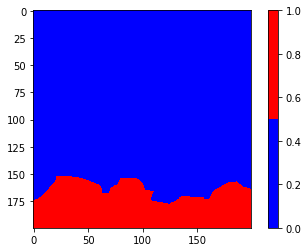

In [37]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['blue', 'red'])
# Example: Creating a 2D array
# Replace this with your array
array = arrays[3] == 255

array = array[800:1000,200:400]

# Plot the array
plt.imshow(array, cmap=cmap)  
plt.colorbar()  # To show a color bar representing the scale
plt.title('')
plt.show()


In [ ]:
mask = arrays[0] == 255
masked_array = ma.array(arrays[0], mask=mask)


In [ ]:
# Flatten the array into a list of (row_index, column_index, value) tuples
flattened_with_indices = [(i, j,  masked_array[i, j]) 
                          for i in range(masked_array.shape[0]) 
                          for j in range(masked_array.shape[1]) 
                          
                          if not ma.is_masked(masked_array[i, j])]

In [ ]:
flattened_sorted = sorted(flattened_with_indices, key=lambda x: x[2], reverse=True)

In [ ]:
len(flattened_sorted)